# BASICS 03 - Training Classifier with MLR (or Histogram Comparison)

# TODO:
- implement a classifier with HC in torch
- creates a dataset_info() to tune hyperparameters accordingly
- check for having an homeostasis rule that is not too restrictive
- check if there is homeostasis only on the clustering phase

In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd '../HOTS'

from network import network
from tools import HOTS_Dataset, get_loader, fit_MLR, predict_MLR, score_classif_events, score_classif_time
import os, tonic

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/INT/grimaldi.a/Documents/projets/HOTS/newhots/HOTS


# Train the classifier

In [10]:
train = True
original_dataset = tonic.datasets.POKERDVS(save_to='../../Data', train=train, transform = tonic.transforms.NumpyAsType(int))

In [11]:
#for poker DVS
sensor_size = original_dataset.sensor_size
name = 'homhots'
tau = (0.7,1.4,2.8)
homeo = (2,1)
timestr = '2021-12-17_poker'
tau_cla = 20

In [12]:
hots = network(name = name, tau = tau, homeo = homeo, timestr = timestr, camsize=(sensor_size[0], sensor_size[1]))

In [13]:
model, loss = fit_MLR(hots, tau_cla)

Number of training samples: 48
load existing model


# Run the classifier on the testing set

In [14]:
likelihood, true_target, timestamps = predict_MLR(hots, model, tau_cla)

Number of testing samples: 20
device -> cuda - num workers -> 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.44it/s]


## Get score as a function of the events number

Mean accuracy: 97.89999999999999%


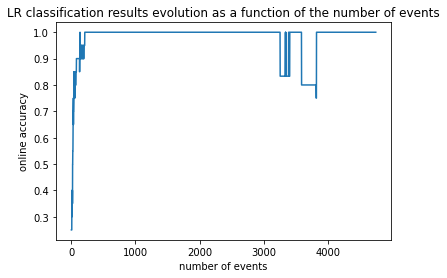

In [15]:
meanac, onlinac, lastac, truepos, falsepos = score_classif_events(likelihood, true_target)

## Get score as a function of time

/home/INT/grimaldi.a/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/INT/grimaldi.a/.local/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Mean accuracy: 93.8%


/home/INT/grimaldi.a/Documents/projets/HOTS/newhots/HOTS/tools.py:374: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


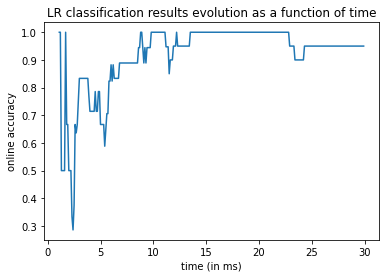

In [16]:
timestep = 100
meanac, onlinac, lastac, truepos, falsepos = score_classif_time(likelihood, true_target, timestamps, timestep, thres=None)